In [0]:
import os
import gc
gc.collect()
os.environ['KAGGLE_USERNAME'] = "yourId"
os.environ['KAGGLE_KEY'] = "yourKey"

In [0]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 72kB/s 


In [0]:
!kaggle datasets download -d ekhtiar/lung-segmentation-for-siimacr-pneumothorax

 99% 64.0M/64.3M [00:01<00:00, 43.0MB/s]
100% 64.3M/64.3M [00:01<00:00, 57.9MB/s]


# Downloading the SIIM-ACR Pneumothorax Segmentation dataset
The data is comprised of images in DICOM format and annotations in the form of image IDs and run-length-encoded (RLE) masks. Some of the images contain instances of pneumothorax (collapsed lung), which are indicated by encoded binary masks in the annotations. Some training images have multiple annotations.

In [0]:
!kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data

100% 1.52G/1.52G [00:33<00:00, 31.7MB/s]
100% 1.52G/1.52G [00:33<00:00, 48.7MB/s]


In [0]:
!7z x lung-segmentation-for-siimacr-pneumothorax.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 67450551 bytes (65 MiB)

Extracting archive: lung-segmentation-for-siimacr-pneumothorax.zip
--
Path = lung-segmentation-for-siimacr-pneumothorax.zip
Type = zip
Physical Size = 67450551

  0%     22% - train_lung_mask.csv                           42% 2 - trained_model.hdf5                            60% 2 - trained_model.hdf5                            79% 2 - trained_model.hdf5                            97% 2 - trained_model.hdf5                           

In [0]:
!7z x siim-acr-pneumothorax-segmentation-data.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1636224881 bytes (1561 MiB)

Extracting archive: siim-acr-pneumothorax-segmentation-data.zip
 11% 4096 Open              --
Path = siim-acr-pneumothorax-segmentation-data.zip
Type = zip
Physical Size = 1636224881

  0%      1% 516 - dicom-images-test/1.2.276.0.7230 . 8323329.5953.1517875193.45019.dcm                                                                                 2% 1050 - dicom-images-test/1.2.276.0.7 . 329.6116.1517875196.610774.dcm   

In [0]:
import numpy as np
import pandas as pd

In [0]:
import tensorflow as tf
import cv2
from skimage import transform
from skimage.filters import threshold_otsu
from skimage.util import img_as_ubyte
from skimage import morphology, io, color, exposure, img_as_float, transform
from skimage.feature import local_binary_pattern
# To calculate a normalized histogram
from skimage.util.shape import view_as_blocks
from skimage.transform import rescale, resize
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize

In [0]:
import pydicom
from glob import glob
from tqdm import tqdm

# Pre-processing(Lung Boundary Segmentation)


## Lung Boundary Detection using UNet model
UNet is a Fully Convolutional Neural Network used for semantic segmentation.
The model has 5 million parameters and has been trained on the Montgomery dataset.The model takes a 256x256 floating point image as input and returns a masking image of the same datatype and dimensions.Following cell depicts the structure in detail.

In [0]:
model_dir = '/content/trained_model.hdf5'
lung_seg_model = tf.keras.models.load_model(model_dir, custom_objects=None, compile=True)
lung_seg_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                  

The following function does these steps:


1.   Resizes the image to (256,256)
2.   Applies Histogram Equalization
3.   Normalizes the image by subtracting the mean and dividing it by the std dev.



In [0]:
def get_lung_seg_tensor(img, batch_size, seg_size, n_channels):
    
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((batch_size, seg_size, seg_size, n_channels))

        # Process Image
        #pixel_array = pydicom.read_file(file_path).pixel_array
        pixel_array = img
        image_resized = cv2.resize(pixel_array, (seg_size, seg_size))
        image_resized = exposure.equalize_hist(image_resized)
        image_resized = np.array(image_resized, dtype=np.float64)
        image_resized -= image_resized.mean()
        image_resized /= image_resized.std()
        # Store Image
        X[0,] = np.expand_dims(image_resized, axis=2)

        return X

The following function takes an image and a mask image, returns with only the Region of Interest(ROI) present based on the OTSU threshold of the mask image.
In our case the ROI are the lung lobes in the Chest X-ray.

In [0]:
def crop_lungs(org_img,thresh_img):
  im_size = org_img.shape
  if(org_img.shape != thresh_img):
    thresh_img = transform.resize(thresh_img,im_size)
  otsu_thresh = threshold_otsu(thresh_img)
  new_im = np.full(im_size,255)
  #print(org_img.shape," ",thresh_img.shape)
  for i in range(im_size[0]):
    for j in range(im_size[1]):
      if(thresh_img[i][j] > otsu_thresh):
        new_im[i][j] = org_img[i][j]
  #new_im = org_img>thresh_img
  return new_im

In [0]:
seg_size = 256

In [0]:
test_img = "/content/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.5682.1517875189.580785/1.2.276.0.7230010.3.1.3.8323329.5682.1517875189.580784/1.2.276.0.7230010.3.1.4.8323329.5682.1517875189.580786.dcm"

In [0]:
img = get_lung_seg_tensor(pydicom.read_file(test_img).pixel_array,1,seg_size,1)
seg_mask = lung_seg_model.predict(img).reshape((seg_size,seg_size))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


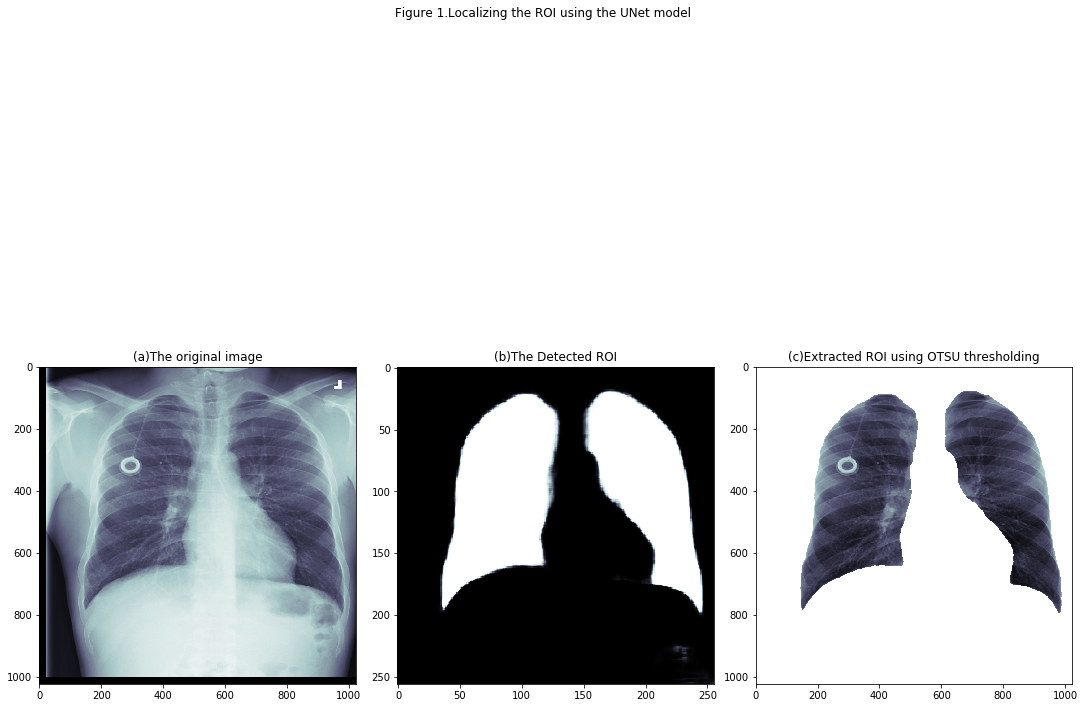

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize = (15,15))
fig.suptitle('Figure 1.Localizing the ROI using the UNet model')
ax1.imshow(pydicom.read_file(test_img).pixel_array,cmap = 'bone')
ax1.title.set_text('(a)The original image')
ax2.imshow(seg_mask, cmap = 'bone')
ax2.title.set_text('(b)The Detected ROI')
ax3.title.set_text('(c)Extracted ROI using OTSU thresholding')
im3  = crop_lungs(pydicom.read_file(test_img).pixel_array,seg_mask)
ax3.imshow(im3, cmap = 'bone')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [0]:
from skimage import feature
class LBP:
  def __init__(self,points = 24, radius = 8):
    self.points = points
    self.radius = radius
  def feature_vector(self,image,eps = 1e-7,method = 'uniform'):
    lbp = feature.local_binary_pattern(image, self.points, self.radius, method= "uniform" )
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, self.points + 3),range=(0, self.points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    return hist

An example of the given annotated labels
The annotated labels are given in the following format
If 'EncodedPixels' = -1 then no Pneumothorax

*   If 'EncodedPixels' = -1 then no Pneumothorax
*   Else 'EncodedPixels' = RLE(Pneumothorax)

In the following example 
ImageId 0 and 1 do not have pneumothorax whereas ImageIdf 2,3 and 3 have pneumothorax


In [0]:
df = pd.read_csv('train-rle.csv')

In [0]:
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [0]:
print("Total no. of examples in the SIIM-ACR Pneumothorax Segmentation dataset are ",len(df.index))

Total no. of examples in the SIIM-ACR Pneumothorax Segmentation dataset are  11582


In [0]:
import sys
sys.path.insert(0, '/content/dicom-images-train')

In [0]:
import glob
import os
all_paths = []
all_paths = sorted(glob.glob('/content/dicom-images-train/**/*.dcm',recursive = True))

using 8 neighboring points with 1 pixel radius for unifrom LBP

In [0]:
seg_size = 256
eps = 1e-7
ULBP = LBP(points = 8 , radius = 1)
training_counter = 0

# Feature Extraction
In machine learning, Feature Extraction is the process of arriving at a set of derived values that are intended to be informative and non-redundant from an inital set of raw values.The end product of this process is called a *feature vector*.The *feature vector* needs to be such that the classifier gets all the information it needs in a manner in which it understands.
## Local Binary Patterns
Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.

LBP can be used to extract texture features from an image in the following way


1.   Divide the examined image into cells
2.   For each pixel in a cell, compare the pixel to each of its 8 neighbors 
3.   Follow the pixels along a circle, i.e. clockwise
4.   Where the center pixel's value is greater than the neighbor's value, write "0". Otherwise, write "1". This gives an 8-digit binary number
5.   Compute the histogram, over the cell, of the frequency of each "number" occurring
6. Normalize the histogram
7. Concatenate (normalized) histograms of all cells. This gives a feature vector for the entire image.

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTo-iaSOU_-hWBBLAWFeu6KIFPUcEuyXks2FM_4Pe05ETPaMLP3)

**Figure 1**.Example of LBP computation for the pixel with value *'4'* results in the binary string *'001110100'*

## Uniform Local Binary Patterns
A Local Binary Pattern is said to be [*uniform*](https://www.hindawi.com/journals/isrn/2013/429347/) if and only if has at most two 1->0 or 0->1 transitions when traversed **circularly**

### Concept of uniform patterns

1.   Greatly reduces the size of the feature vector when it comes to higher number of sampling points
2.   [Experiments](http://www.scholarpedia.org/article/Local_Binary_Patterns) have shown that uniform patterns occur more frequently in texture images than non-uniform patterns



In [0]:
train_X = []
train_Y = []
block_size = 64
block_step = block_size
img_size = 512
training_counter = 0
for path in all_paths:
  #if (training_counter%500 == 0):
  #  print("So far length of Xtrain ",len(train_X)," length of Ytrain ",len(train_Y))
  img = pydicom.read_file(path).pixel_array
  img_norm = get_lung_seg_tensor(img,1,seg_size,1)
  seg_mask = lung_seg_model.predict(img_norm).reshape((seg_size,seg_size))
  seg_mask = resize(seg_mask,output_shape=(img_size,img_size))
  cropped = crop_lungs(img,seg_mask)
  tiles = view_as_blocks(cropped, block_shape=(block_size, block_size))
  #tiles = get_tile_images(cropped, 128, 128)
  X_i = np.array([ULBP.feature_vector(j) for i in tiles for j in i]).flatten()
  train_X.append(X_i)
  
  y =  df.loc[df['ImageId'] == path.split('/')[-1][:-4]].values.tolist()
  try:
    if '-1' in y[0][1]:
      train_Y.append(0)
    else:
      train_Y.append(1)
  except IndexError:
    train_Y.append(0)
  training_counter = training_counter + 1
X = np.array(train_X)
Y = np.array(train_Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
X.shape

(10, 2560)

In [0]:
Y.shape

(500,)

# Splitting the Dataset


1.   **Training set**—A subset to train a model(80% of the total dataset).
2.   **Test set**—A subset to test the trained model(20% of the total dataset)

![alt text](https://developers.google.com/machine-learning/crash-course/images/PartitionTwoSets.svg)

**Figure 2**. Visualization of slicing a single data set into a training set and test set.





In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size = 0.2)

# Classification using Support Vector Machine
A Support Vector Machine is defined as a constrained optimization problem to maximize the margin of separating hyperplanes.

>$ y_{i} =(x_{i}^{T}\beta+\beta_{0}) $

The values of $\beta$ are optimized by the following constrained optimiazation problem

>$\min_{\beta_{0},\beta_{1}}{||\beta||}$

subject to

>$y_{i}(x_{i}^{T}\beta+\beta_{0})\geq1- \epsilon_{i}$

>$ \forall_{i} \in (1,N) $

$\epsilon_{i}$ = the amount by which $(x_{i}^{T}\beta+\beta_{0})$ is on the wrong side

Using implementation from 
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

# Training the SVM model

In [0]:
from sklearn.svm import LinearSVC
model = LinearSVC(C=100.0, random_state=42)
model.fit(X_train,Y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

# Evaluating the model
Accuracy and Senesitivity(True Positive Rate) can be calculated from the following equations:

>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

>$Sensitivity =\frac{TP}{TP+FN} $

In [0]:
Y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
sensitivity = tp/(tp+fn)

In [0]:
print("Accuracy is (ULBP Feature Extraction) with Lung segmentation with SVM classifier",accuracy_score(Y_test,Y_pred))

Accuracy is (ULBP Feature Extraction) with Lung segmentation with SVM classifier 0.7820811945870275


In [0]:
result_dict = {'Y_true':Y_test,'Y_pred':Y_pred}
result_df = pd.DataFrame(result_dict)
result_df.to_csv('Pneumo_ULBP_SVM_Lung_Seg.csv')